In [ ]:
import torch
try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn'T find the torchinfo module... downloading the module.")
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  print(f"[INFO] Couldn't find the going_modular scripts... downloading them from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

In [ ]:
import os
import zipfile
import requests

from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza-steak-sushi"
zip_path = data_path/"pizza-steak-sushi.zip"

if not image_path.is_dir():
  image_path.mkdir(parents=True, exist_ok=True)
  if not zip_path.is_dir():
    with open(data_path/"pizza-steak-sushi.zip", 'wb') as f:
      response = requests.get("https://github.com/Kagankakao/My-AI-Journey/raw/refs/heads/main/data/pizza-steak-sushi.zip")
      f.write(response.content)

  with zipfile.ZipFile(data_path/"pizza-steak-sushi.zip", 'r') as zip_ref:
    zip_ref.extractall(image_path)
  os.remove(data_path/"pizza-steak-sushi.zip")

train_dir = image_path/"train"
test_dir = image_path/"test"

In [ ]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transformer = transforms.Compose([transforms.Resize((256, 256)),
                                  transforms.ToTensor(),
                                  normalize])

In [ ]:
import os
from going_modular.going_modular import data_setup

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    transformer,
    BATCH_SIZE,
    NUM_WORKERS)

import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
)

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=40,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape                              Output Shape                             Param #                                  Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]                         [1, 3]                                   --                                       Partial
├─Sequential (features)                                      [1, 3, 224, 224]                         [1, 1280, 7, 7]                          --                                       False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]                         [1, 32, 112, 112]                        --                                       False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]                         [1, 32, 112, 112]                        (864)                                    False
│    │    └─BatchNorm2d (1)                 

In [ ]:
params = model.features.parameters()
next(iter(params)).shape

torch.Size([32, 3, 3, 3])

In [ ]:
from going_modular.going_modular import engine
from timeit import default_timer as timer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start_timer = timer()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results = engine.train(model,
                       train_dataloader,
                       test_dataloader,
                       optimizer,
                       loss_fn,
                       10,
                       device)
end_timer = timer()
results, end_timer

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0491 | train_acc: 0.4453 | test_loss: 0.9198 | test_acc: 0.5076
Epoch: 2 | train_loss: 0.9125 | train_acc: 0.6836 | test_loss: 0.8388 | test_acc: 0.6922
Epoch: 3 | train_loss: 0.7373 | train_acc: 0.8789 | test_loss: 0.6606 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7353 | train_acc: 0.7031 | test_loss: 0.6005 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6065 | train_acc: 0.8867 | test_loss: 0.6199 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5711 | train_acc: 0.8008 | test_loss: 0.5633 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5589 | train_acc: 0.8047 | test_loss: 0.5784 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4968 | train_acc: 0.8047 | test_loss: 0.4929 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4682 | train_acc: 0.9180 | test_loss: 0.5033 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.5249 | train_acc: 0.7812 | test_loss: 0.5297 | test_acc: 0.8561


({'train_loss': [1.049068607389927,
   0.9124574437737465,
   0.737328939139843,
   0.735332190990448,
   0.6065140664577484,
   0.5711478404700756,
   0.5589479245245457,
   0.49675996601581573,
   0.4681989438831806,
   0.5249397084116936],
  'train_acc': [0.4453125,
   0.68359375,
   0.87890625,
   0.703125,
   0.88671875,
   0.80078125,
   0.8046875,
   0.8046875,
   0.91796875,
   0.78125],
  'test_loss': [0.9197603464126587,
   0.838845411936442,
   0.66058882077535,
   0.6005324920018514,
   0.6199098626772562,
   0.563342293103536,
   0.5783883730570475,
   0.4928673605124156,
   0.5033161044120789,
   0.5296680927276611],
  'test_acc': [0.5075757575757576,
   0.6922348484848485,
   0.8759469696969697,
   0.8655303030303031,
   0.9071969696969697,
   0.8967803030303031,
   0.8863636363636364,
   0.8967803030303031,
   0.8967803030303031,
   0.8560606060606061]},
 28299.748113577)

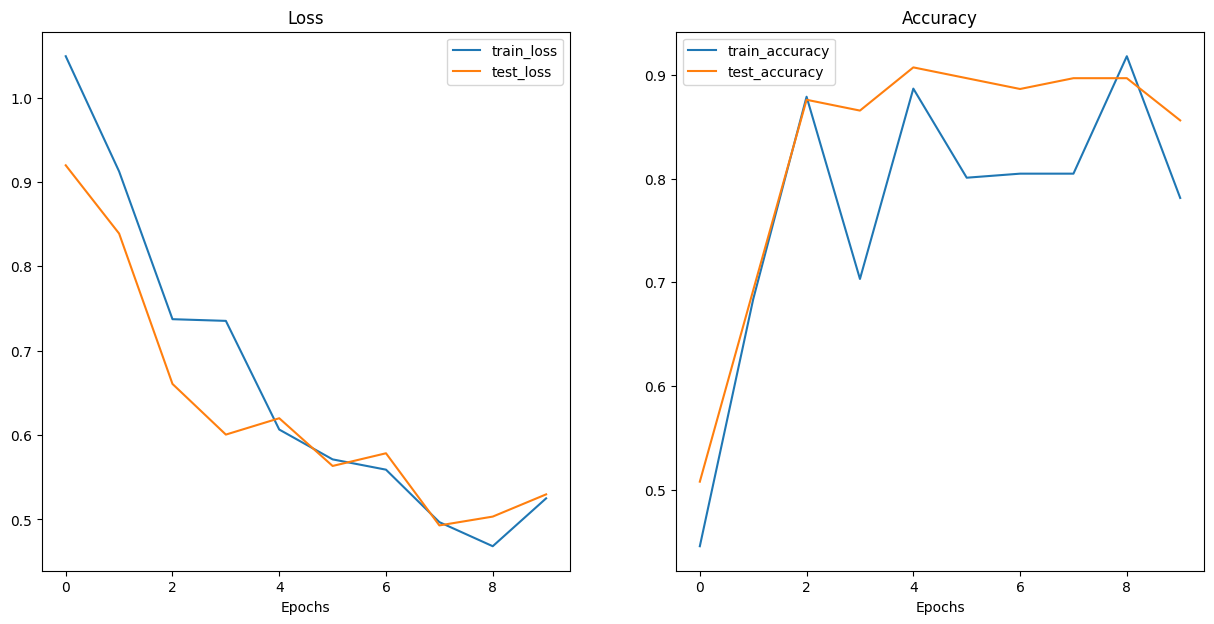

In [ ]:
# Ploting the curves
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find the helper_functions.py... downloading from GitHub")
  response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(response.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [ ]:
from helper_functions import plot_loss_curves
from typing import List, Tuple
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        loss_fn: torch.nn.Module,
                        device: str):

  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  transform = transforms.Compose([transforms.Resize((256,256)),
                                  transforms.ToTensor(),
                                  normalize])
  img = Image.open(image_path)
  img = transform(img).unsqueeze(dim=0)

  model.eval()
  with torch.inference_mode():
    y_logits = model(img)

  y_probs = torch.softmax(y_logits, dim=1)

  y_pred_idx = torch.argmax(y_probs, dim=1)

  plt.title(f"Pred: {class_names[y_pred_idx]} | Prob: {y_probs.max():.3f}")
  plt.imshow(Image.open(image_path))
  plt.axis("off")

In [ ]:
test_dir

PosixPath('data/pizza-steak-sushi/test')

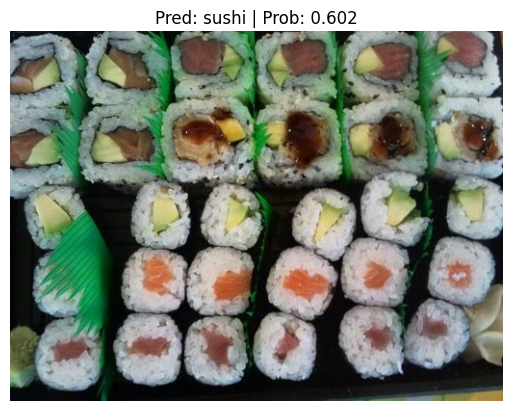

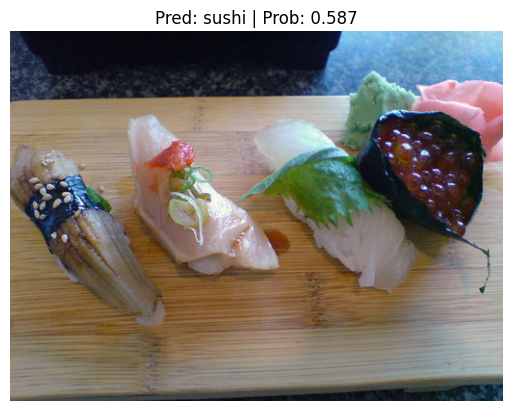

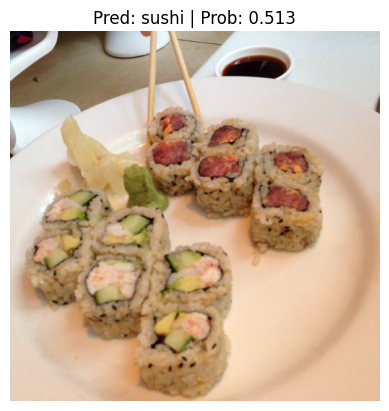

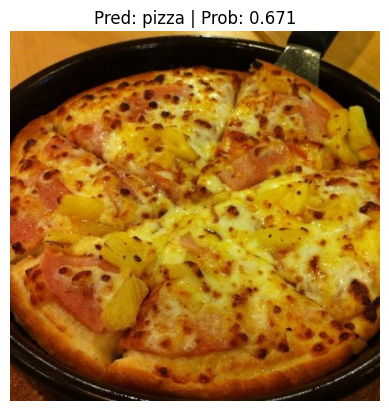

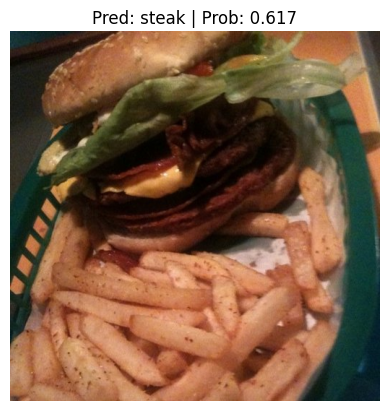

In [ ]:
import random

test_image_paths = list(Path(test_dir).glob("*/*.jpg"))

rand_test_image_paths = random.sample(test_image_paths, k=5)

for image_path in rand_test_image_paths:
    pred_and_plot_image(model,
                        image_path,
                        loss_fn,
                        device)
    plt.show()

In [ ]:
rand_test_image_paths

[PosixPath('data/pizza-steak-sushi/test/sushi/1987407.jpg'),
 PosixPath('data/pizza-steak-sushi/test/sushi/46797.jpg'),
 PosixPath('data/pizza-steak-sushi/test/sushi/3806282.jpg'),
 PosixPath('data/pizza-steak-sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza-steak-sushi/test/pizza/2508636.jpg')]

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(torch.tensor([[0.7311, 0.2689, 0.0001],
                                [0.2689, 0.7311, 0.9999]]))
df

,0,1,2
0,0.7311,0.2689,0.0001
1,0.2689,0.7311,0.9999


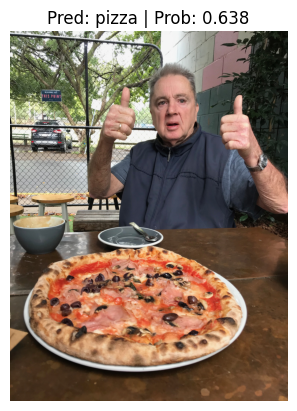

In [ ]:
response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true")

with open("custom_image.png", "wb") as f:
  f.write(response.content)
image_path = "custom_image.png"
pred_and_plot_image(model,
                    image_path,
                    loss_fn,
                    device)